# Convolutional Neural Networks (CNNs) with PyTorch

This tutorial covers implementing CNNs for image classification, including MNIST and CIFAR-10 datasets with modern CNN techniques.

## 1. Setup and Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST, CIFAR10

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
from PIL import Image

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Device-agnostic setup
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using CUDA: {torch.cuda.get_device_name()}")
    print(f"Available GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using MPS (Apple Silicon)")
else:
    device = torch.device('cpu')
    print("Using CPU")

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"Device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Using CUDA: Tesla T4
Available GPU memory: 14.7 GB
PyTorch version: 2.8.0+cu126
Torchvision version: 0.23.0+cu126
Device: cuda


## 2. MNIST Dataset and Simple CNN

Let's start with the MNIST dataset and build a simple CNN.

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 529kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.58MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.38MB/s]


MNIST Dataset:
Training samples: 60000
Test samples: 10000
Image shape: torch.Size([1, 28, 28])
Number of classes: 10 (digits 0-9)


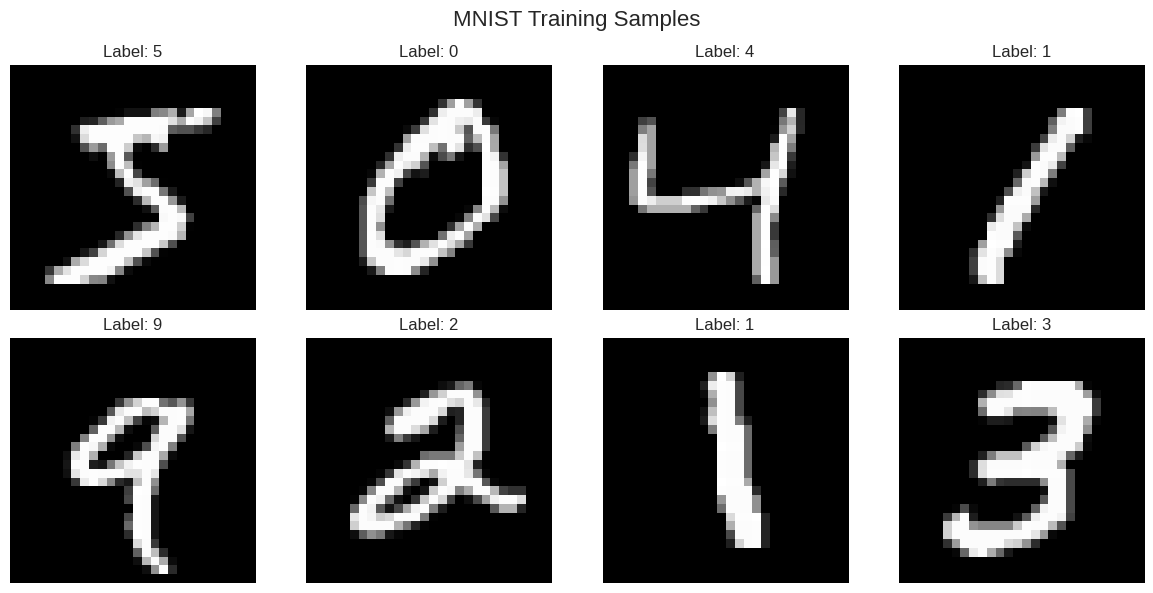

In [2]:
# Define transforms for MNIST
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

# Download and load MNIST dataset
mnist_train_dataset = MNIST(root='./data', train=True, download=True, transform=mnist_transform)
mnist_test_dataset = MNIST(root='./data', train=False, download=True, transform=mnist_transform)

# Create data loaders
batch_size = 128
mnist_train_loader = DataLoader(mnist_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
mnist_test_loader = DataLoader(mnist_test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"MNIST Dataset:")
print(f"Training samples: {len(mnist_train_dataset)}")
print(f"Test samples: {len(mnist_test_dataset)}")
print(f"Image shape: {mnist_train_dataset[0][0].shape}")
print(f"Number of classes: 10 (digits 0-9)")

# Visualize some MNIST samples
def visualize_dataset_samples(dataset, title, num_samples=8):
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    fig.suptitle(title, fontsize=16)

    for i in range(num_samples):
        img, label = dataset[i]
        ax = axes[i // 4, i % 4]

        if img.shape[0] == 1:  # Grayscale
            ax.imshow(img.squeeze(), cmap='gray')
        else:  # Color
            # Denormalize for display
            img = img.numpy().transpose(1, 2, 0)
            img = (img - img.min()) / (img.max() - img.min())
            ax.imshow(img)

        ax.set_title(f'Label: {label}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

visualize_dataset_samples(mnist_train_dataset, "MNIST Training Samples")

## 3. Simple CNN Architecture for MNIST

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()

        # Feature extraction layers
        self.features = nn.Sequential(
            # First convolutional block
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 28x28 -> 28x28
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),  # 28x28 -> 28x28
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 28x28 -> 14x14

            # Second convolutional block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # 14x14 -> 14x14
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # 14x14 -> 14x14
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 14x14 -> 7x7
        )

        # Classifier layers
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten for fully connected layers
        x = self.classifier(x)
        return x

# Create model and move to device
mnist_model = SimpleCNN(num_classes=10).to(device)
print(f"MNIST CNN Model:")
print(mnist_model)

# Count parameters
total_params = sum(p.numel() for p in mnist_model.parameters())
trainable_params = sum(p.numel() for p in mnist_model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Test the model with a sample input
sample_input = torch.randn(1, 1, 28, 28).to(device)
with torch.no_grad():
    output = mnist_model(sample_input)
    print(f"\nSample output shape: {output.shape}")
    print(f"Sample output: {output}")

MNIST CNN Model:
SimpleCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

Total parameters: 467,818
Trainable parameters: 467,818

Sample output shape: torch.Size([1, 10])


## 4. Training Function for CNNs

In [4]:
def train_cnn(model, train_loader, test_loader, criterion, optimizer,
              num_epochs=10, device='cpu', print_every=1):
    """
    Train CNN model and return training history
    """
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct_train += pred.eq(target.view_as(pred)).sum().item()
            total_train += target.size(0)

        # Calculate training metrics
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100. * correct_train / total_train

        # Evaluation phase
        model.eval()
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.argmax(dim=1, keepdim=True)
                correct_test += pred.eq(target.view_as(pred)).sum().item()
                total_test += target.size(0)

        test_accuracy = 100. * correct_test / total_test

        # Store metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        if epoch % print_every == 0 or epoch == num_epochs - 1:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.4f}, '
                  f'Train Acc: {train_accuracy:.2f}%, '
                  f'Test Acc: {test_accuracy:.2f}%')

    return train_losses, train_accuracies, test_accuracies

def evaluate_cnn(model, test_loader, device, class_names=None):
    """
    Evaluate CNN model and return detailed metrics
    """
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)

            all_predictions.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    accuracy = accuracy_score(all_targets, all_predictions)

    print(f"Test Accuracy: {accuracy:.4f}")

    if class_names:
        print("\nClassification Report:")
        print(classification_report(all_targets, all_predictions,
                                  target_names=class_names))

    cm = confusion_matrix(all_targets, all_predictions)

    return accuracy, all_predictions, all_targets, cm

## 5. Train MNIST CNN

In [5]:
# Define loss function and optimizer for MNIST
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mnist_model.parameters(), lr=0.001)

print("Training MNIST CNN...")
print("=" * 50)

# Train the model
mnist_train_losses, mnist_train_accs, mnist_test_accs = train_cnn(
    mnist_model, mnist_train_loader, mnist_test_loader,
    criterion, optimizer, num_epochs=5, device=device
)

print("\nMNIST Training completed!")

Training MNIST CNN...
Epoch [1/5], Train Loss: 0.2672, Train Acc: 91.55%, Test Acc: 98.60%
Epoch [2/5], Train Loss: 0.0928, Train Acc: 97.30%, Test Acc: 98.99%
Epoch [3/5], Train Loss: 0.0700, Train Acc: 97.94%, Test Acc: 98.79%
Epoch [4/5], Train Loss: 0.0580, Train Acc: 98.32%, Test Acc: 99.27%
Epoch [5/5], Train Loss: 0.0492, Train Acc: 98.54%, Test Acc: 99.36%

MNIST Training completed!


## 6. Visualize MNIST Results

Test Accuracy: 0.9936

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       0.99      1.00      0.99      1032
           3       1.00      0.99      1.00      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



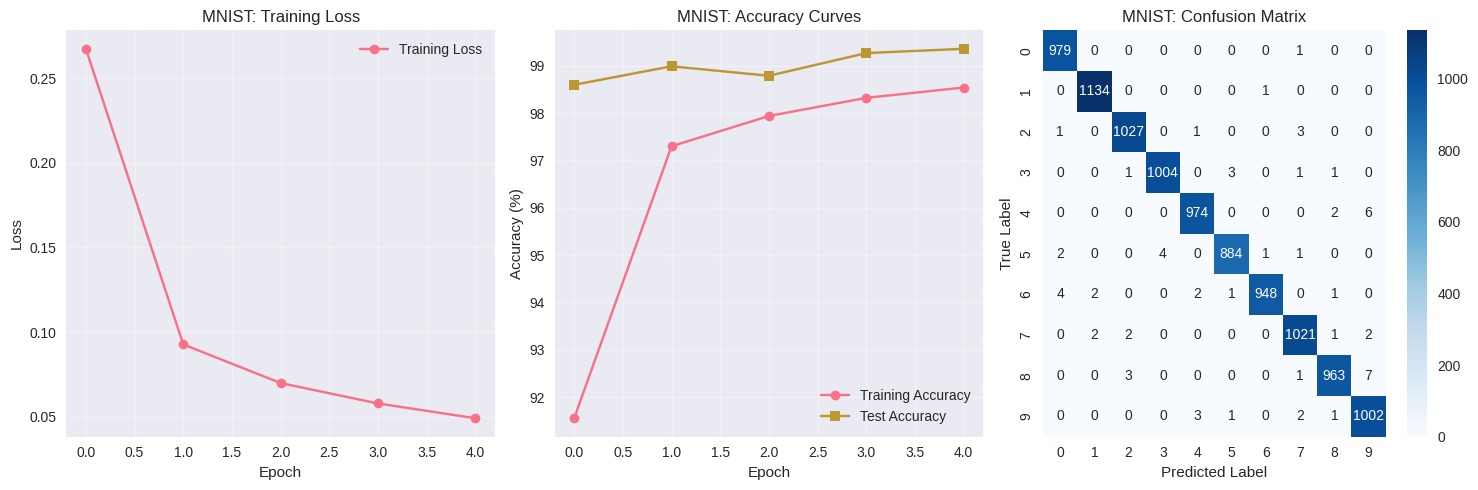

In [6]:
# Plot training curves for MNIST
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(mnist_train_losses, label='Training Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MNIST: Training Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(mnist_train_accs, label='Training Accuracy', marker='o')
plt.plot(mnist_test_accs, label='Test Accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('MNIST: Accuracy Curves')
plt.legend()
plt.grid(True, alpha=0.3)

# Evaluate on test set
mnist_digit_names = [str(i) for i in range(10)]
accuracy, predictions, targets, cm = evaluate_cnn(
    mnist_model, mnist_test_loader, device, mnist_digit_names
)

# Plot confusion matrix
plt.subplot(1, 3, 3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=mnist_digit_names, yticklabels=mnist_digit_names)
plt.title('MNIST: Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()

## 7. Visualize CNN Features and Predictions

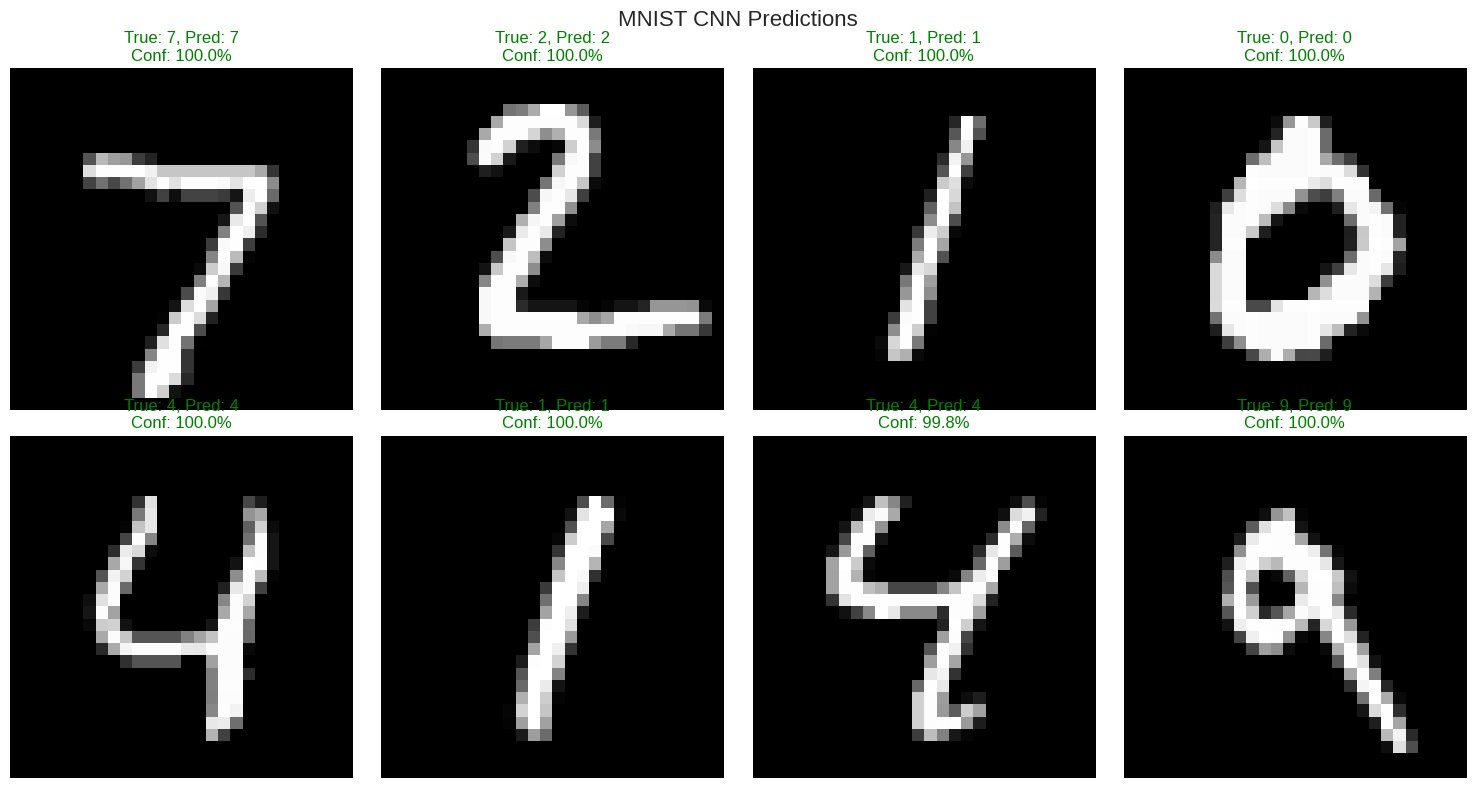

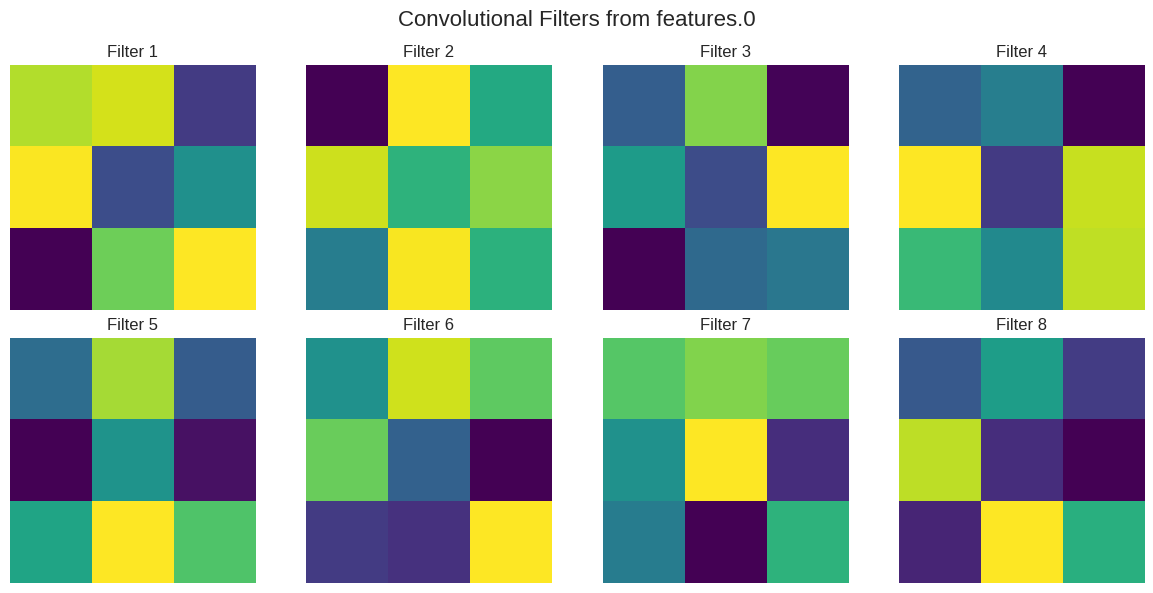

In [7]:
def visualize_predictions(model, test_loader, device, num_samples=8):
    """
    Visualize model predictions on test samples
    """
    model.eval()

    # Get a batch of test data
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)

    # Make predictions
    with torch.no_grad():
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)
        predicted = outputs.argmax(dim=1)

    # Move to CPU for visualization
    images = images.cpu()
    labels = labels.cpu()
    predicted = predicted.cpu()
    probabilities = probabilities.cpu()

    # Plot predictions
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    fig.suptitle('MNIST CNN Predictions', fontsize=16)

    for i in range(num_samples):
        ax = axes[i // 4, i % 4]

        # Display image
        img = images[i].squeeze()
        ax.imshow(img, cmap='gray')

        # Set title with prediction info
        true_label = labels[i].item()
        pred_label = predicted[i].item()
        confidence = probabilities[i][pred_label].item() * 100

        color = 'green' if true_label == pred_label else 'red'
        ax.set_title(f'True: {true_label}, Pred: {pred_label}\nConf: {confidence:.1f}%',
                    color=color, fontsize=12)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

def visualize_conv_filters(model, layer_name='features.0', num_filters=8):
    """
    Visualize convolutional filters
    """
    # Get the first convolutional layer
    conv_layer = dict(model.named_modules())[layer_name]
    filters = conv_layer.weight.data.cpu()

    # Plot filters
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    fig.suptitle(f'Convolutional Filters from {layer_name}', fontsize=16)

    for i in range(min(num_filters, filters.shape[0])):
        ax = axes[i // 4, i % 4]

        # Get filter and normalize for visualization
        filter_img = filters[i, 0]  # First channel for grayscale
        filter_img = (filter_img - filter_img.min()) / (filter_img.max() - filter_img.min())

        ax.imshow(filter_img, cmap='viridis')
        ax.set_title(f'Filter {i+1}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize predictions and filters
visualize_predictions(mnist_model, mnist_test_loader, device)
visualize_conv_filters(mnist_model)

## 8. CIFAR-10 Dataset and Advanced CNN

Now let's work with the more challenging CIFAR-10 dataset.

100%|██████████| 170M/170M [00:03<00:00, 48.7MB/s]


CIFAR-10 Dataset:
Training samples: 50000
Test samples: 10000
Image shape: torch.Size([3, 32, 32])
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


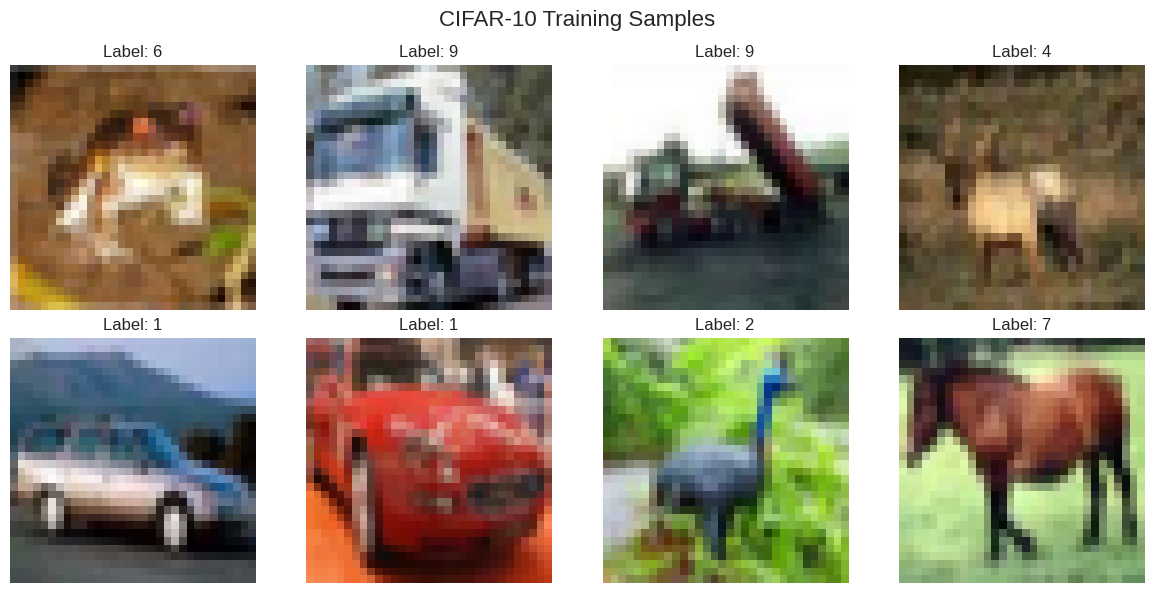

In [8]:
# CIFAR-10 class names
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

# Define transforms for CIFAR-10 with data augmentation
cifar10_transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

cifar10_transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Download and load CIFAR-10 dataset
cifar10_train_dataset = CIFAR10(root='./data', train=True, download=True,
                               transform=cifar10_transform_train)
cifar10_test_dataset = CIFAR10(root='./data', train=False, download=True,
                              transform=cifar10_transform_test)

# Create data loaders
cifar10_train_loader = DataLoader(cifar10_train_dataset, batch_size=batch_size,
                                 shuffle=True, num_workers=2)
cifar10_test_loader = DataLoader(cifar10_test_dataset, batch_size=batch_size,
                                shuffle=False, num_workers=2)

print(f"CIFAR-10 Dataset:")
print(f"Training samples: {len(cifar10_train_dataset)}")
print(f"Test samples: {len(cifar10_test_dataset)}")
print(f"Image shape: {cifar10_train_dataset[0][0].shape}")
print(f"Classes: {cifar10_classes}")

# Visualize CIFAR-10 samples (without augmentation for clarity)
cifar10_vis_dataset = CIFAR10(root='./data', train=True, download=False,
                             transform=transforms.ToTensor())
visualize_dataset_samples(cifar10_vis_dataset, "CIFAR-10 Training Samples")

## 9. Advanced CNN Architecture for CIFAR-10

In [9]:
class AdvancedCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(AdvancedCNN, self).__init__()

        # Feature extraction with batch normalization
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 32x32 -> 16x16
            nn.Dropout2d(0.25),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 16x16 -> 8x8
            nn.Dropout2d(0.25),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 8x8 -> 4x4
            nn.Dropout2d(0.25),
        )

        # Global average pooling + classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(256, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Create CIFAR-10 model
cifar10_model = AdvancedCNN(num_classes=10).to(device)
print(f"CIFAR-10 Advanced CNN Model:")
print(cifar10_model)

# Count parameters
total_params = sum(p.numel() for p in cifar10_model.parameters())
trainable_params = sum(p.numel() for p in cifar10_model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Test the model with a sample input
sample_input = torch.randn(1, 3, 32, 32).to(device)
with torch.no_grad():
    output = cifar10_model(sample_input)
    print(f"\nSample output shape: {output.shape}")

CIFAR-10 Advanced CNN Model:
AdvancedCNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.25, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_siz

## 10. Train CIFAR-10 CNN with Learning Rate Scheduling

In [10]:
# Define loss function and optimizer for CIFAR-10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cifar10_model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

print("Training CIFAR-10 Advanced CNN...")
print("=" * 50)
print(f"Note: This will take longer due to more complex architecture and dataset")
print(f"Using device: {device}")

# Modified training function with learning rate scheduling
def train_cnn_with_scheduler(model, train_loader, test_loader, criterion, optimizer, scheduler,
                           num_epochs=10, device='cpu', print_every=1):
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    learning_rates = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct_train += pred.eq(target.view_as(pred)).sum().item()
            total_train += target.size(0)

        # Step the scheduler
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)

        # Calculate training metrics
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100. * correct_train / total_train

        # Evaluation phase
        model.eval()
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.argmax(dim=1, keepdim=True)
                correct_test += pred.eq(target.view_as(pred)).sum().item()
                total_test += target.size(0)

        test_accuracy = 100. * correct_test / total_test

        # Store metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        if epoch % print_every == 0 or epoch == num_epochs - 1:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'LR: {current_lr:.6f}, '
                  f'Train Loss: {train_loss:.4f}, '
                  f'Train Acc: {train_accuracy:.2f}%, '
                  f'Test Acc: {test_accuracy:.2f}%')

    return train_losses, train_accuracies, test_accuracies, learning_rates

# Train the model (using fewer epochs for demo)
cifar10_train_losses, cifar10_train_accs, cifar10_test_accs, learning_rates = train_cnn_with_scheduler(
    cifar10_model, cifar10_train_loader, cifar10_test_loader,
    criterion, optimizer, scheduler, num_epochs=6, device=device
)

print("\nCIFAR-10 Training completed!")

Training CIFAR-10 Advanced CNN...
Note: This will take longer due to more complex architecture and dataset
Using device: cuda
Epoch [1/6], LR: 0.001000, Train Loss: 1.7633, Train Acc: 32.99%, Test Acc: 48.61%
Epoch [2/6], LR: 0.001000, Train Loss: 1.4625, Train Acc: 45.58%, Test Acc: 55.45%
Epoch [3/6], LR: 0.000500, Train Loss: 1.3185, Train Acc: 52.38%, Test Acc: 62.00%
Epoch [4/6], LR: 0.000500, Train Loss: 1.1788, Train Acc: 57.63%, Test Acc: 67.23%
Epoch [5/6], LR: 0.000500, Train Loss: 1.1144, Train Acc: 60.23%, Test Acc: 68.26%
Epoch [6/6], LR: 0.000250, Train Loss: 1.0685, Train Acc: 62.17%, Test Acc: 70.21%

CIFAR-10 Training completed!


## 11. Visualize CIFAR-10 Results

Test Accuracy: 0.7021

Classification Report:
              precision    recall  f1-score   support

    airplane       0.76      0.71      0.74      1000
  automobile       0.86      0.91      0.89      1000
        bird       0.54      0.56      0.55      1000
         cat       0.56      0.33      0.42      1000
        deer       0.58      0.68      0.63      1000
         dog       0.55      0.63      0.59      1000
        frog       0.65      0.84      0.73      1000
       horse       0.81      0.70      0.75      1000
        ship       0.84      0.84      0.84      1000
       truck       0.91      0.81      0.86      1000

    accuracy                           0.70     10000
   macro avg       0.71      0.70      0.70     10000
weighted avg       0.71      0.70      0.70     10000



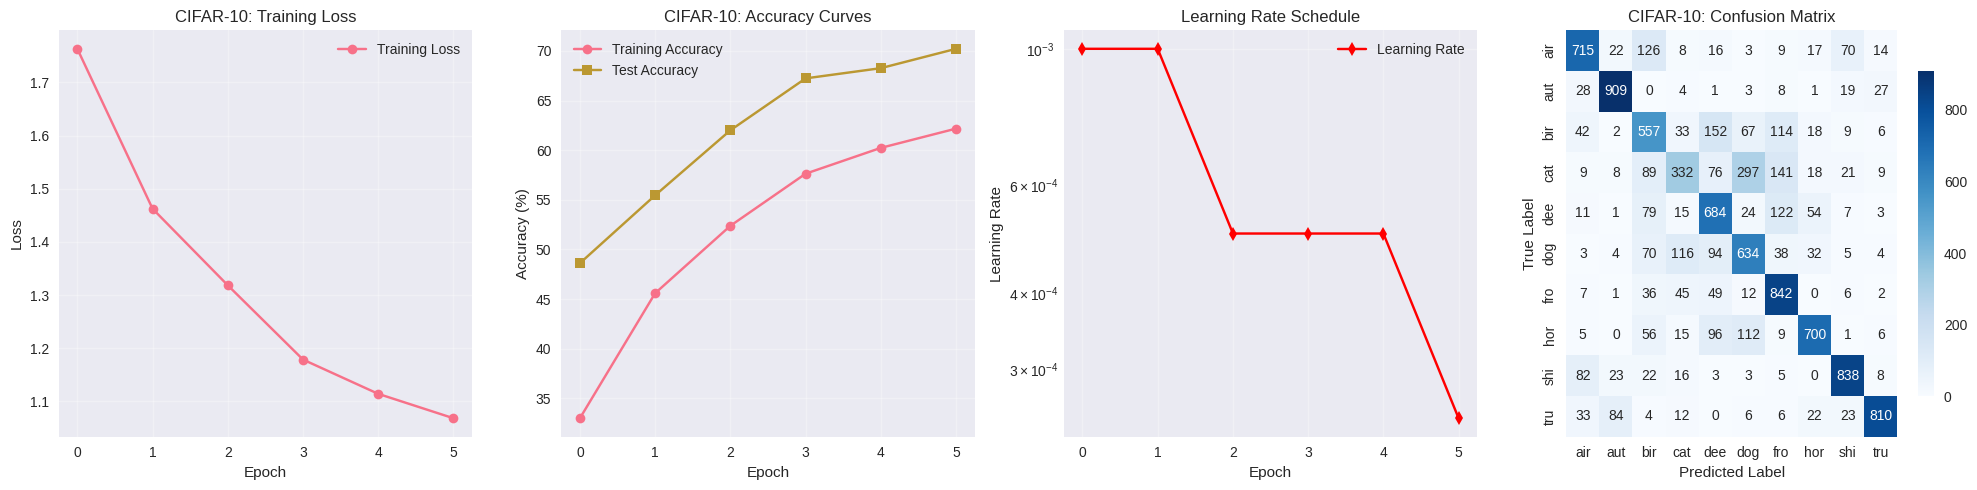

In [11]:
# Plot training curves for CIFAR-10
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.plot(cifar10_train_losses, label='Training Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CIFAR-10: Training Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 4, 2)
plt.plot(cifar10_train_accs, label='Training Accuracy', marker='o')
plt.plot(cifar10_test_accs, label='Test Accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('CIFAR-10: Accuracy Curves')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 4, 3)
plt.plot(learning_rates, label='Learning Rate', marker='d', color='red')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Evaluate CIFAR-10 model
accuracy, predictions, targets, cm = evaluate_cnn(
    cifar10_model, cifar10_test_loader, device, cifar10_classes
)

# Plot confusion matrix
plt.subplot(1, 4, 4)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'shrink': 0.8},
            xticklabels=[c[:3] for c in cifar10_classes],
            yticklabels=[c[:3] for c in cifar10_classes])
plt.title('CIFAR-10: Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()

## 12. Compare MNIST vs CIFAR-10 Performance

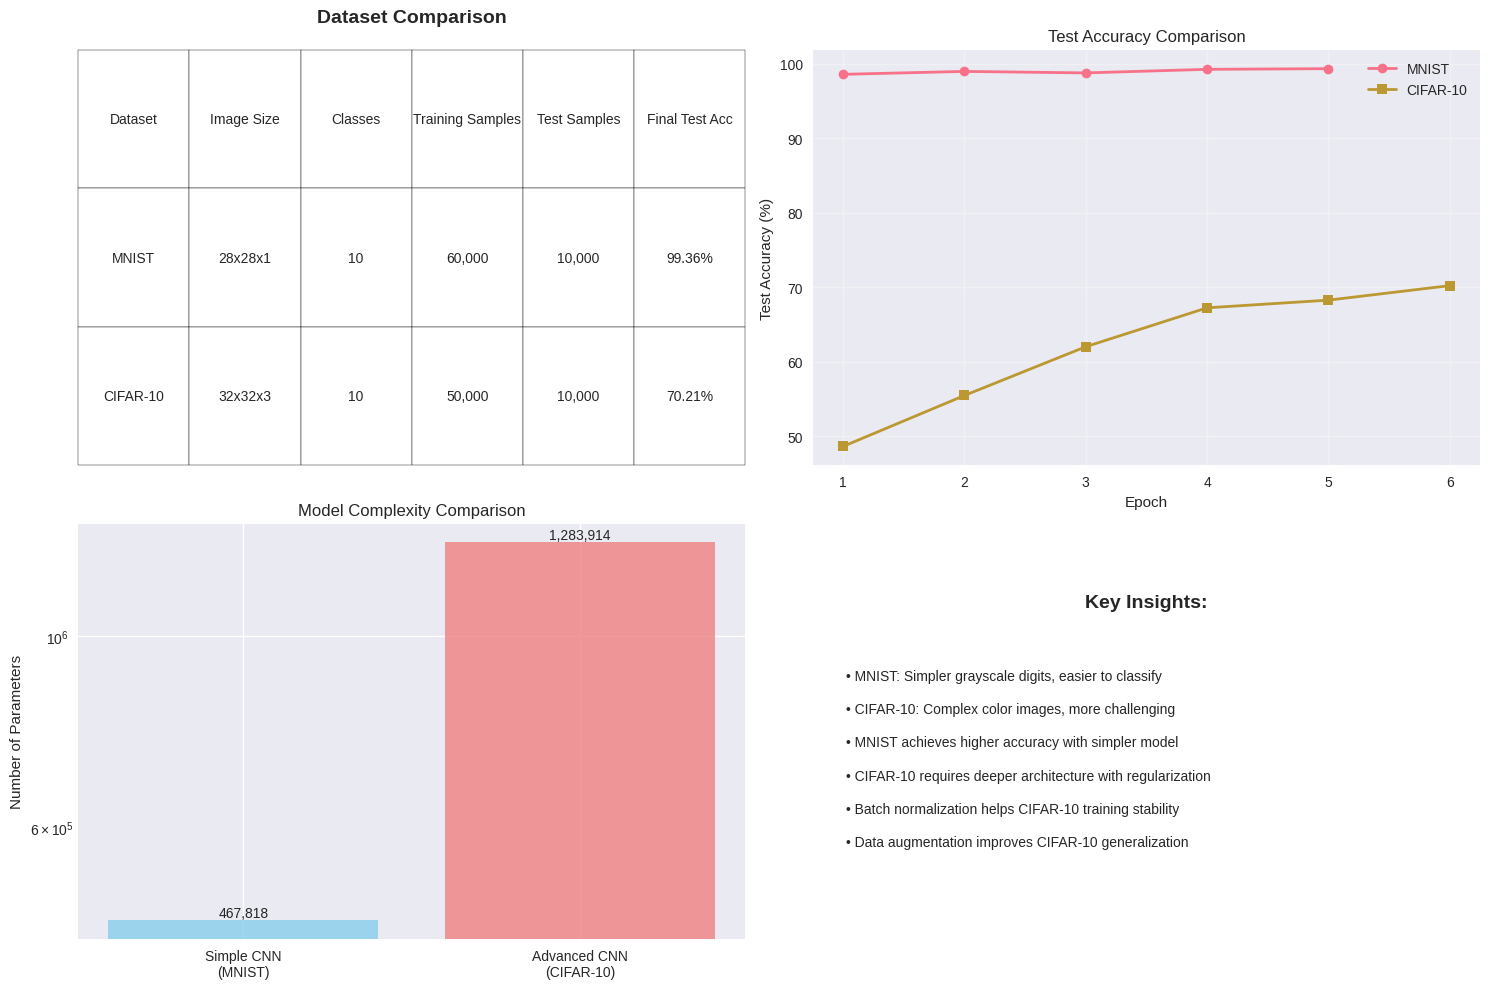

In [12]:
# Create comparison visualization
plt.figure(figsize=(15, 10))

# Model comparison table
plt.subplot(2, 2, 1)
plt.axis('off')
comparison_data = {
    'Dataset': ['MNIST', 'CIFAR-10'],
    'Image Size': ['28x28x1', '32x32x3'],
    'Classes': [10, 10],
    'Training Samples': ['60,000', '50,000'],
    'Test Samples': ['10,000', '10,000'],
    'Final Test Acc': [f'{mnist_test_accs[-1]:.2f}%', f'{cifar10_test_accs[-1]:.2f}%']
}
df_comparison = pd.DataFrame(comparison_data)
table = plt.table(cellText=df_comparison.values, colLabels=df_comparison.columns,
                 cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
plt.title('Dataset Comparison', pad=20, fontsize=14, fontweight='bold')

# Accuracy comparison
plt.subplot(2, 2, 2)
epochs_mnist = range(1, len(mnist_test_accs) + 1)
epochs_cifar = range(1, len(cifar10_test_accs) + 1)
plt.plot(epochs_mnist, mnist_test_accs, label='MNIST', marker='o', linewidth=2)
plt.plot(epochs_cifar, cifar10_test_accs, label='CIFAR-10', marker='s', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Model complexity comparison
plt.subplot(2, 2, 3)
mnist_params = sum(p.numel() for p in mnist_model.parameters())
cifar10_params = sum(p.numel() for p in cifar10_model.parameters())

models = ['Simple CNN\n(MNIST)', 'Advanced CNN\n(CIFAR-10)']
params = [mnist_params, cifar10_params]
colors = ['skyblue', 'lightcoral']

bars = plt.bar(models, params, color=colors, alpha=0.8)
plt.ylabel('Number of Parameters')
plt.title('Model Complexity Comparison')
plt.yscale('log')

# Add value labels on bars
for bar, param in zip(bars, params):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{param:,}', ha='center', va='bottom', fontsize=10)

# Sample predictions comparison
plt.subplot(2, 2, 4)
plt.axis('off')
plt.text(0.5, 0.8, 'Key Insights:', ha='center', fontsize=14, fontweight='bold')
insights = [
    '• MNIST: Simpler grayscale digits, easier to classify',
    '• CIFAR-10: Complex color images, more challenging',
    '• MNIST achieves higher accuracy with simpler model',
    '• CIFAR-10 requires deeper architecture with regularization',
    '• Batch normalization helps CIFAR-10 training stability',
    '• Data augmentation improves CIFAR-10 generalization'
]
for i, insight in enumerate(insights):
    plt.text(0.05, 0.65 - i*0.08, insight, fontsize=10, va='top')

plt.tight_layout()
plt.show()

## 13. Key Takeaways and Best Practices

### What We Learned

1. **CNN Architecture**: Convolutional layers extract spatial features, pooling reduces dimensions
2. **Modern Techniques**: Batch normalization, dropout, and data augmentation improve performance
3. **Device Agnostic**: All models work seamlessly on CPU, CUDA, or MPS
4. **Data Preprocessing**: Proper normalization and augmentation are crucial
5. **Progressive Complexity**: MNIST → CIFAR-10 shows increasing model complexity needs

### CNN Best Practices

- **Start Simple**: Begin with basic architectures, add complexity gradually
- **Use Batch Normalization**: Improves training stability and convergence
- **Apply Dropout**: Prevents overfitting, especially in fully connected layers
- **Data Augmentation**: Increases dataset diversity for better generalization
- **Learning Rate Scheduling**: Adjust learning rate during training
- **Monitor Both Metrics**: Watch training/validation accuracy and loss
- **GPU Utilization**: Use device-agnostic code for maximum performance

### Architecture Guidelines

- **Convolution**: Extract spatial features with learnable filters
- **Pooling**: Reduce spatial dimensions, increase receptive field
- **Activation**: ReLU is standard, others for specific needs
- **Normalization**: BatchNorm after conv layers, before activation
- **Regularization**: Dropout for FC layers, Dropout2d for conv layers

### Common Pitfalls to Avoid

- Don't forget to move data and model to the same device
- Always call `model.eval()` during evaluation
- Use appropriate transforms for training vs. testing
- Monitor for overfitting with validation accuracy
- Be mindful of memory usage with large models/batches

### Next Steps

- **Transfer Learning**: Use pre-trained models (ResNet, VGG, etc.)
- **Advanced Architectures**: Explore ResNet, DenseNet, EfficientNet
- **Object Detection**: YOLO, R-CNN for detecting objects in images
- **Segmentation**: U-Net for pixel-level classification
- **Generative Models**: GANs, VAEs for creating new images

Congratulations! You've successfully built and trained CNNs for image classification. The principles learned here form the foundation for more advanced computer vision tasks.